Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 64, 16]) torch.Size([16, 3]) torch.Size([64, 64, 3])


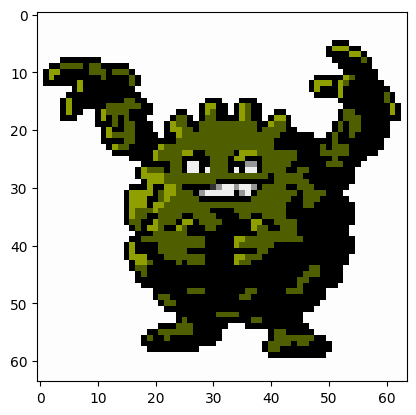

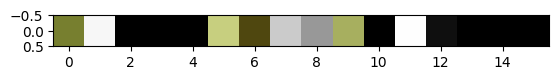

In [1]:
from PIL import Image
import torch
from torchvision import transforms
from torch import nn
import numpy as np

from matplotlib import pyplot as plt

torch.set_printoptions(sci_mode=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

toTensor = transforms.ToTensor()

i = torch.randint(0, 350, (1,)).item()
#i = 383
im = Image.open(f"./dataset/rs/{i}.png").convert("RGB")
indexed = toTensor(im).to(device)
indexed = (indexed * 255).int().permute(1, 2, 0)

palette = torch.zeros(16, 3, device=device) # 16 3
colors = im.getcolors()
for i in range(len(colors)):
    palette[i] = torch.tensor(colors[i][1], device=device)

id = torch.randperm(len(palette))
palette = palette[id]

image = torch.zeros(64, 64, 16, device=device)
for i in range(len(palette)):
    image[:, :, i] = (indexed == palette[i]).all(dim=2)

palette = palette.float() / 256

image_rgb = (image @ palette)
image_rgb = (image_rgb - 0.5) * 2

print(image.shape, palette.shape, image_rgb.shape)

plt.imshow(image_rgb.cpu())
plt.show()

plt.imshow(palette.cpu()[None, ...].detach())
plt.show()


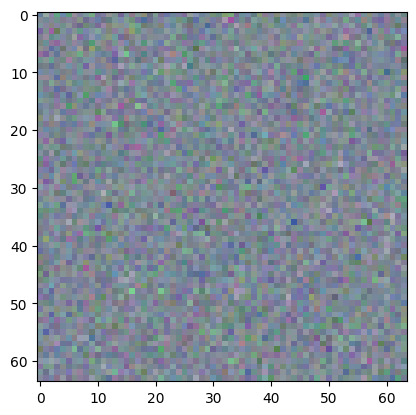

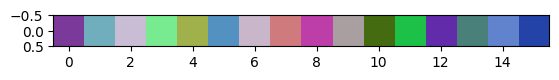

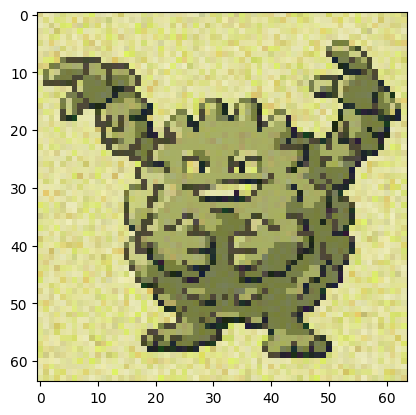

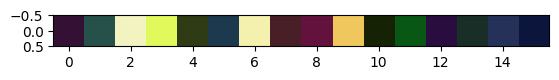

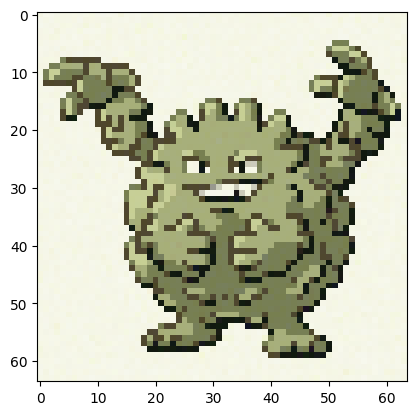

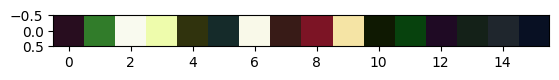

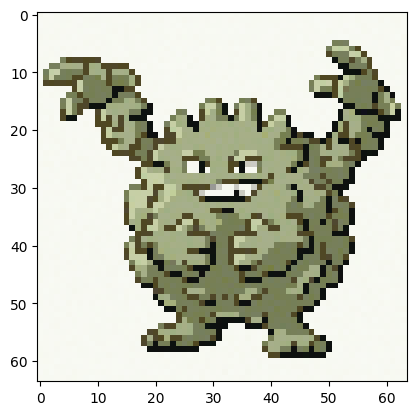

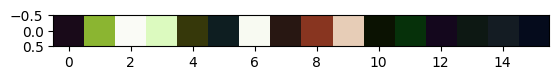

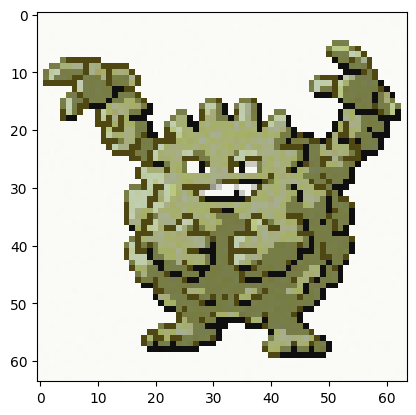

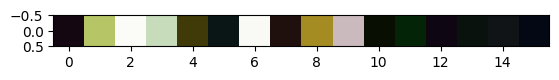

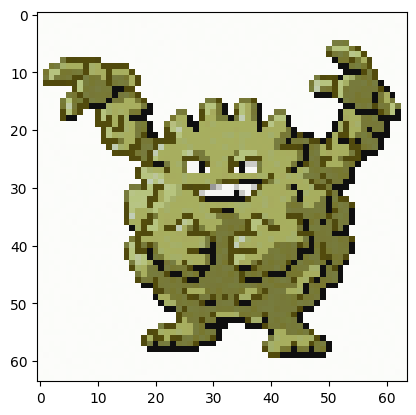

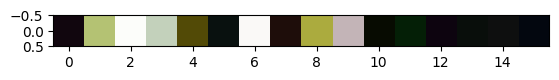

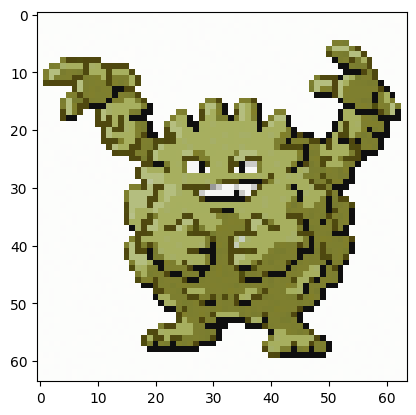

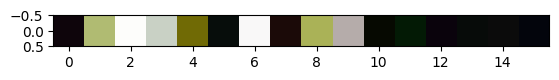

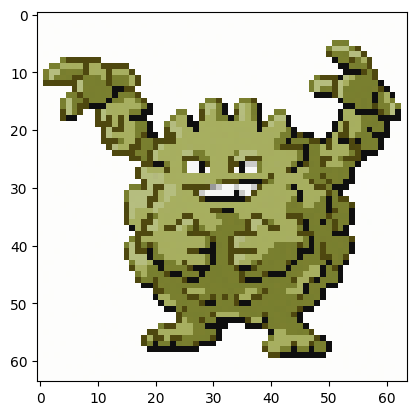

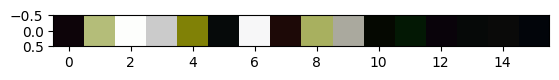

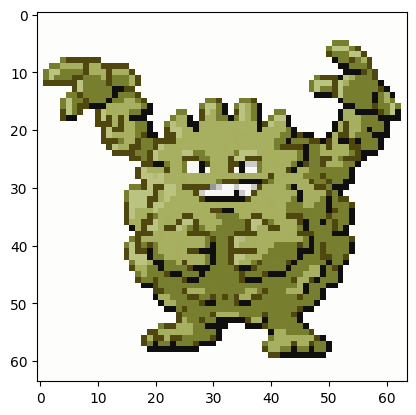

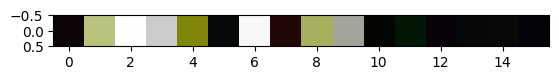

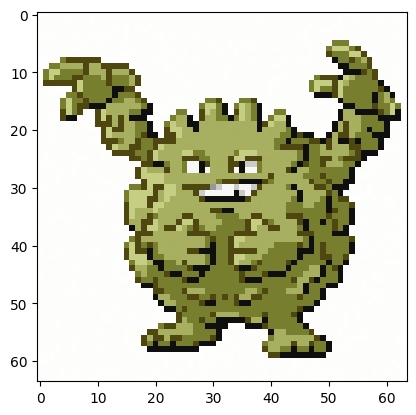

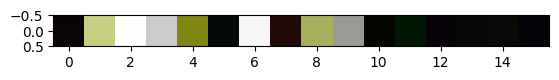

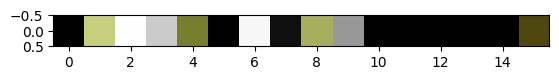

In [2]:
imm = torch.randn(64, 64, 16, device=device, requires_grad=True)
pal = torch.randn(16, 3, device=device, requires_grad=True)

#loss_fn = torch.nn.MSELoss(reduction='none')
optim = torch.optim.Adam([pal, imm], lr=0.01)

L = nn.Sequential(
    nn.Linear(3, 2048),
    nn.ReLU(),
).to(device)
torch.nn.init.normal_(L[0].bias, 0, 0.5)

Lspal = L((palette - 0.5) * 2).sum(dim=0).detach()

def closure():
    optim.zero_grad()

    smm = torch.softmax(imm, dim=2)
    spal = (torch.sigmoid(pal) - 0.5) * 2

    rgb = smm @ spal

    loss = (rgb - image_rgb).abs().mean()
    loss += 5 * (L(spal).sum(dim=0) - Lspal).abs().mean()

    loss.backward()
    return loss

for i in range(2000):
    optim.step(closure)

    if i % 200 == 0:
        rgb = torch.softmax(imm, dim=2) @ torch.sigmoid(pal)
        plt.imshow(rgb.cpu().detach().clip(0,1))
        plt.show()

        ps = torch.sigmoid(pal)
        plt.imshow(ps.cpu()[None, ...].detach())
        plt.show()


ps = torch.sigmoid(pal)

ppal = palette.clone()
indices = torch.zeros(16, dtype=torch.int64, device=device)
for i in range(16):
    indices[i] = (ppal - ps[i]).pow(2).mean(dim=1).min(dim=0).indices
    ppal[indices[i]] = torch.tensor([100, 100, 100], device=device)


pp = palette[indices]
plt.imshow(pp.cpu()[None, ...].detach())
plt.show()


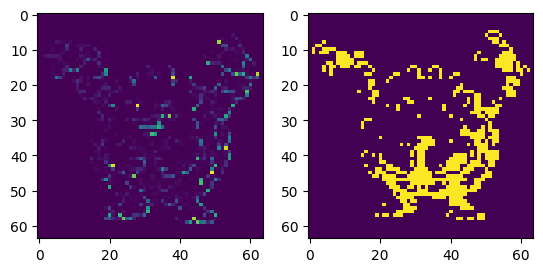

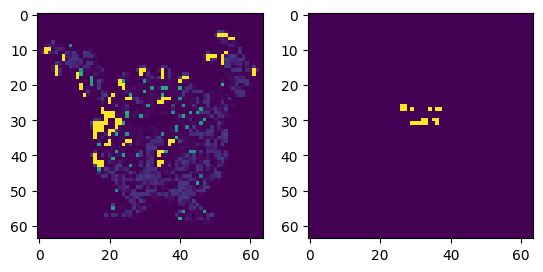

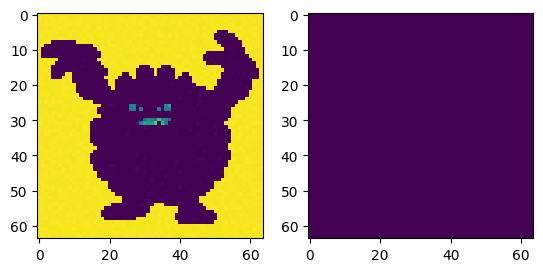

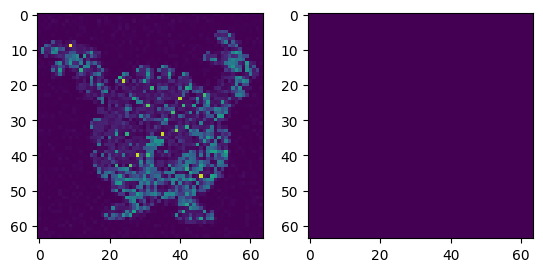

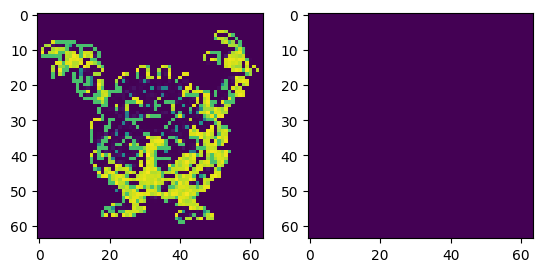

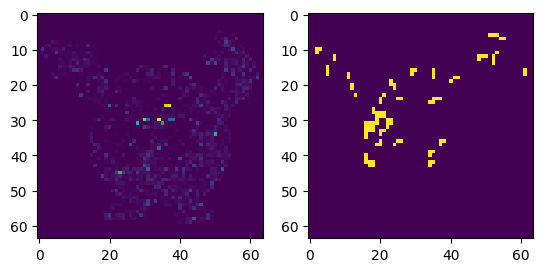

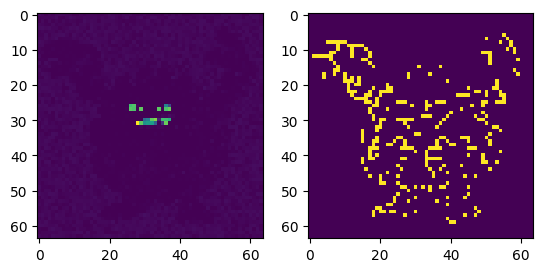

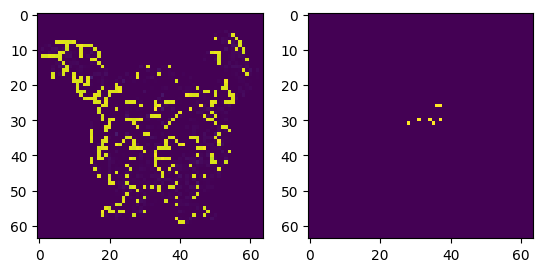

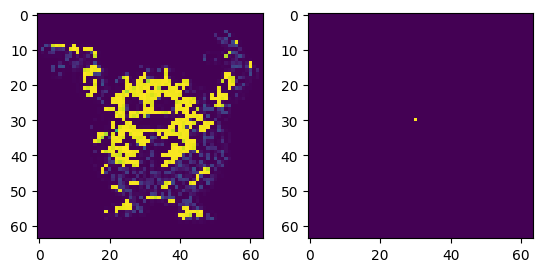

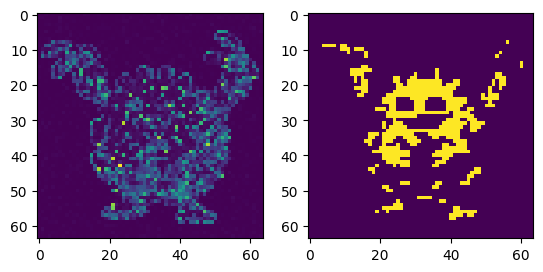

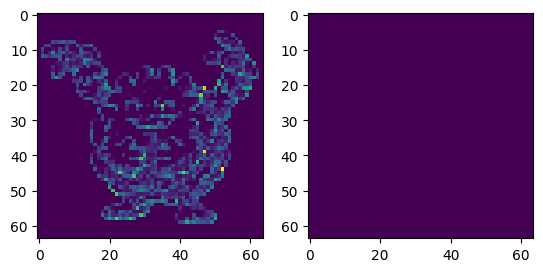

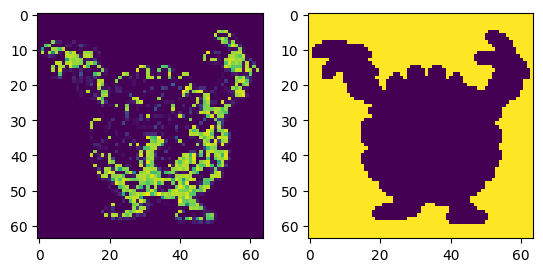

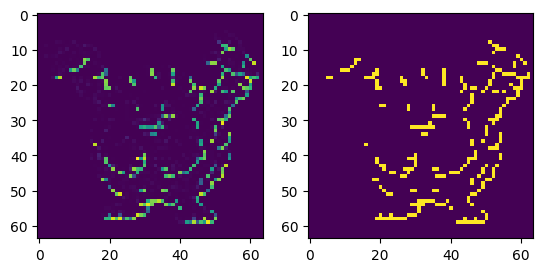

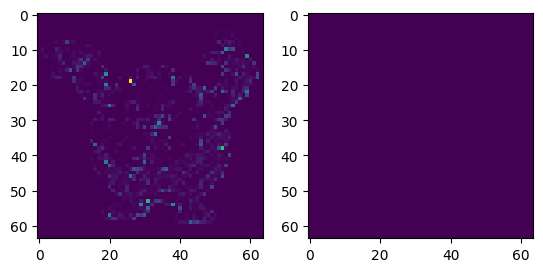

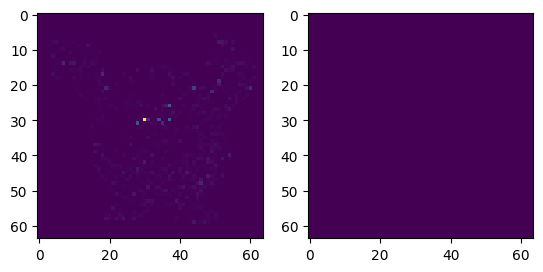

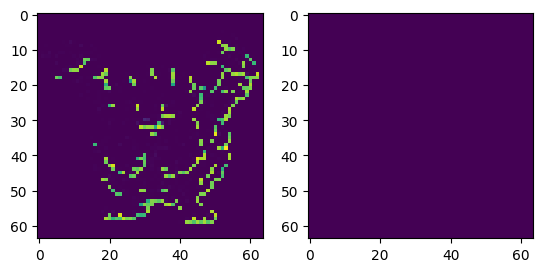

In [3]:
smm = torch.softmax(imm, dim=2)

for i in range(16):
    # subplot two images
    plt.subplot(1, 2, 1)
    plt.imshow(smm[:,:,i].detach().clip(0,1).cpu());
    plt.subplot(1, 2, 2)
    plt.imshow(image[:,:,i].detach().clip(0,1).cpu());
    plt.show()

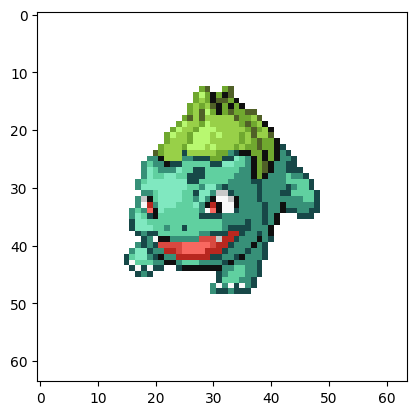

In [4]:
from load_dataset import load_dataset, plot_image
from tqdm import tqdm
from random import randint

pimages = load_dataset().to(device)
pimages.shape # [3, 386, 3, 64, 64]

plot_image(pimages[0, 0, :, :, :])

In [5]:
class PConv(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, bias=False, residual=False):
        super().__init__()
        self.residual = residual
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding='same', bias=bias),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
        )

    def forward(self, x):
        if self.residual:
            return self.conv(x) + x
        return self.conv(x)

class TConv(nn.Module):
    def __init__(self, in_c, out_c, bias=False):
        super().__init__()
        self.tconv = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1,
                               bias=bias),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
        )               
    
    def forward(self, x):
        return self.tconv(x)

class ImageTransformer(nn.Module):
    def __init__(self, in_c=3, out_c=16):
        super().__init__()
        self.emb = nn.Conv2d(in_c, out_c, kernel_size=1, bias=True)
        self.layer1 = nn.TransformerEncoderLayer(d_model=out_c, nhead=4, dim_feedforward=128, batch_first=True)

    def forward(self, x):
        shape = x.shape

        x = self.emb(x)

        x = x.flatten(2, 3).permute(0, 2, 1)
        x = self.layer1(x)
        x = x.permute(0, 2, 1).unflatten(2, shape[2:])

        return x

class PaletteDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.feat0 = nn.Parameter(torch.randn(1, 1, 64))
        self.linear = nn.Linear(64, 16 * 3)

        self.layer1 = nn.TransformerEncoderLayer(d_model=64, nhead=4, dim_feedforward=96, batch_first=True)
        self.layer = nn.TransformerEncoder(self.layer1, num_layers=2)
    
    def forward(self, x):
        # x: [batch, 64, 8, 8]
        
        x = x.flatten(2, 3)
        # x: [batch, 64, 8*8]

        x = x.permute(0, 2, 1)
        # x: [batch, 8*8, 64]

        x = torch.cat([self.feat0.expand(x.shape[0], -1, -1), x], dim=1)
        # x: [batch, 8*8 + 1, 64]

        x = self.layer(x)
        # x: [batch, 8*8 + 1, 64]
        
        x = x[:, 0, :]
        x = self.linear(x)
        # x: [batch, 16 * 3]

        x = x.unflatten(1, (16, 3))
        
        return torch.sigmoid(x) * 2 - 1

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            PConv(3, 16, bias=True, kernel_size=1),
            PConv(16, 16, residual=True),
            PConv(16, 16, residual=True),
            #nn.Dropout(0.2),
            nn.MaxPool2d(2), # 32 x 32

            PConv(16, 32),
            PConv(32, 32, residual=True),
            PConv(32, 32, residual=True),
            #nn.Dropout(0.2),
            nn.MaxPool2d(2), # 16 x 16

            PConv(32, 64),
            PConv(64, 64, residual=True),
            PConv(64, 64, residual=True),
            #nn.Dropout(0.2),
            nn.MaxPool2d(2), # 8 x 8

            #nn.Flatten(),
            #nn.Linear(64 * 8 * 8, 16 * 3),
            #nn.Sigmoid(),
            PaletteDecoder(),
        )


    def forward(self, x):
        x = self.encoder(x)


        return x

  0%|          | 0/50001 [00:00<?, ?it/s]

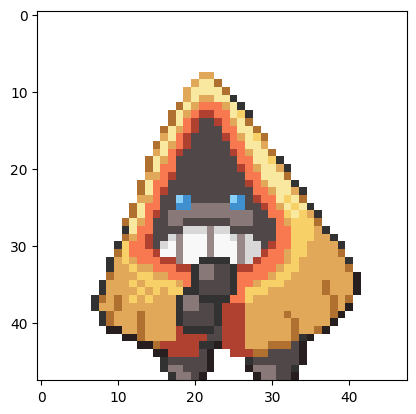

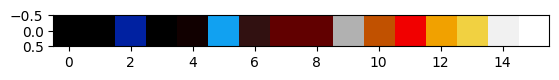

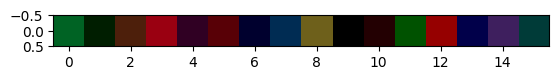

0.54902405:   2%|▏         | 999/50001 [00:06<04:27, 183.41it/s]

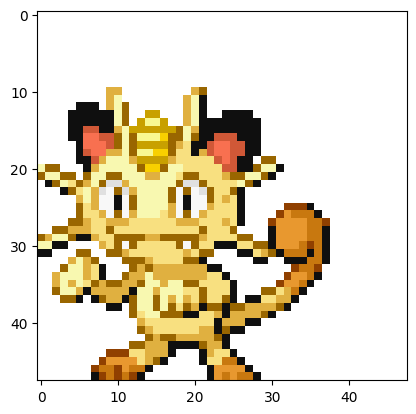

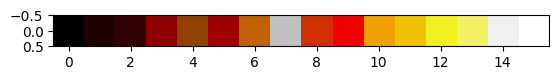

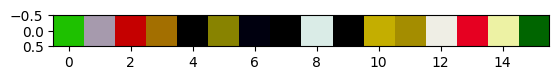

0.48237544:   4%|▍         | 1990/50001 [00:12<04:21, 183.85it/s]

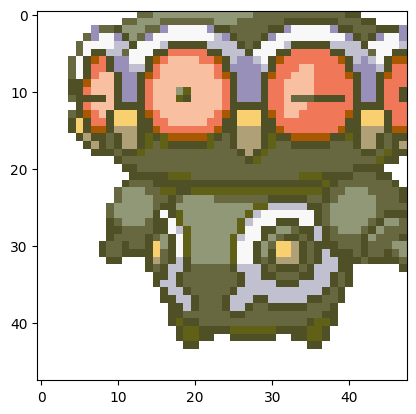

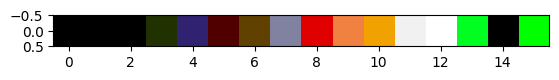

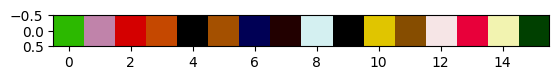

0.60186559:   6%|▌         | 2988/50001 [00:17<04:15, 184.01it/s]

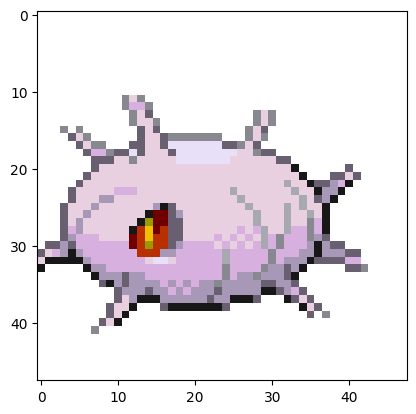

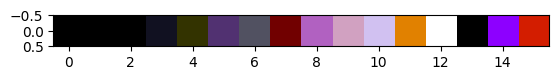

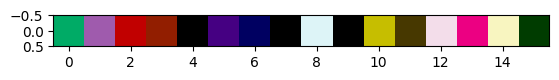

0.56411004:   8%|▊         | 3987/50001 [00:23<04:10, 183.53it/s]

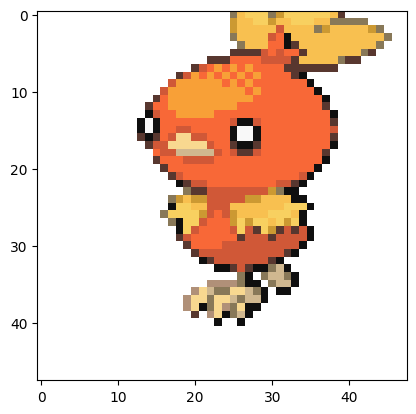

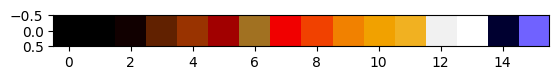

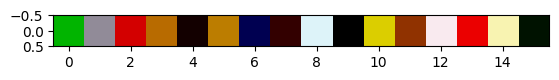

0.61908722:  10%|▉         | 4989/50001 [00:28<04:07, 181.94it/s]

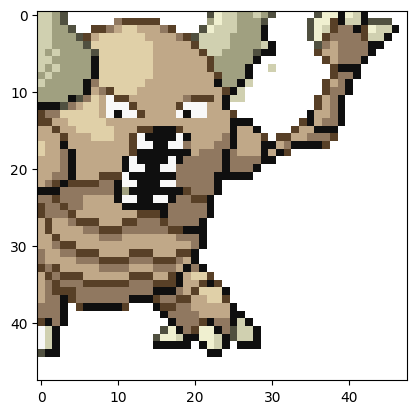

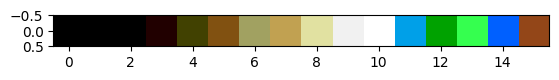

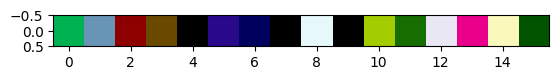

0.54015708:  12%|█▏        | 5989/50001 [00:34<03:57, 185.52it/s]

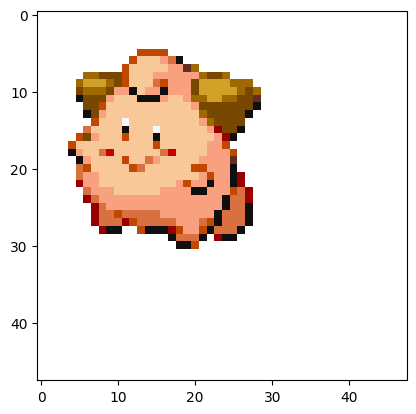

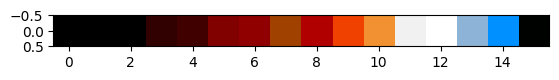

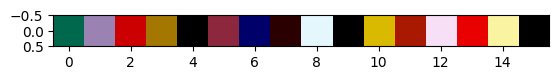

0.52166367:  14%|█▍        | 6986/50001 [00:39<03:55, 183.02it/s]

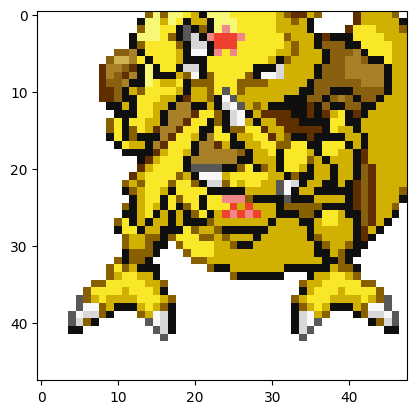

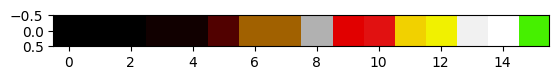

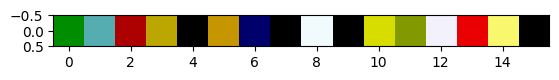

0.59801996:  16%|█▌        | 7986/50001 [00:45<03:49, 182.85it/s]

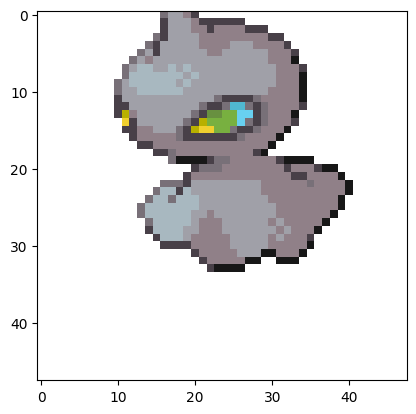

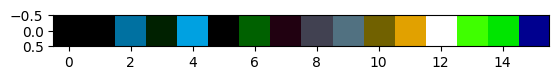

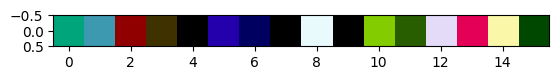

0.65934569:  18%|█▊        | 8998/50001 [00:51<03:41, 185.53it/s]

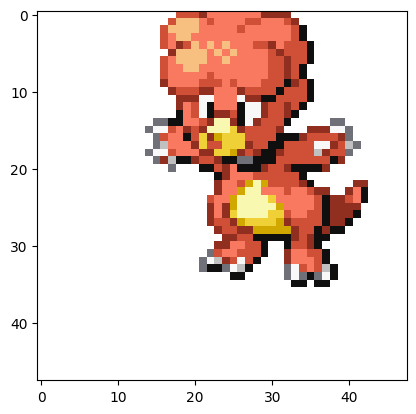

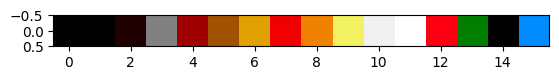

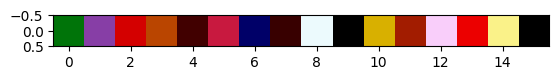

0.51818407:  20%|█▉        | 9983/50001 [00:56<03:38, 182.78it/s]

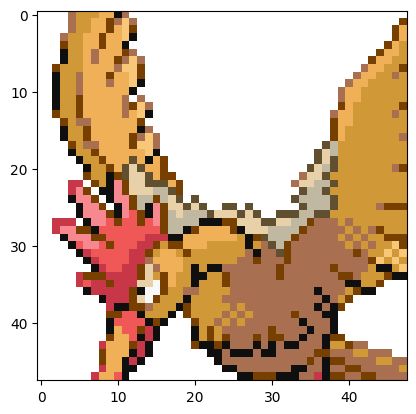

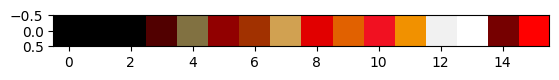

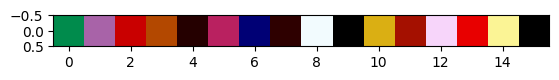

0.46316057:  22%|██▏       | 10996/50001 [01:02<03:54, 166.08it/s]

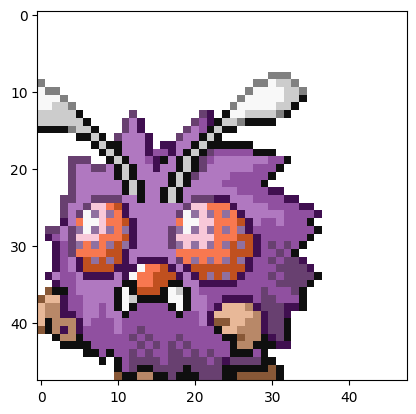

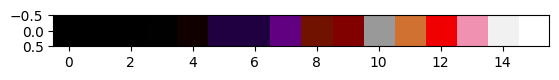

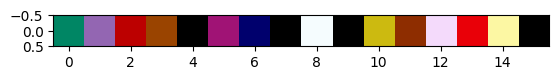

0.47870994:  24%|██▍       | 11982/50001 [01:07<03:27, 182.84it/s]

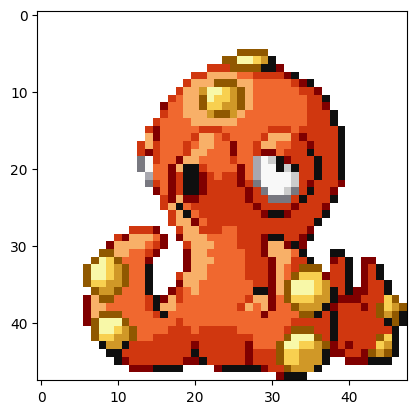

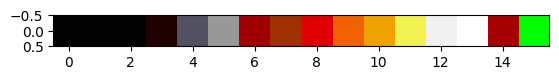

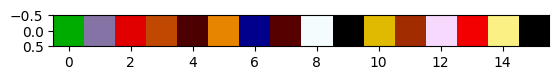

0.49537250:  25%|██▌       | 12657/50001 [01:11<03:31, 176.32it/s]


KeyboardInterrupt: 

In [6]:
bs = 8

L = nn.Sequential(
    nn.Linear(3, 256),
    nn.ReLU(),
).to(device)
torch.nn.init.normal_(L[0].bias, 0, 0.5)

model = AutoEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


#random crop
Crop = transforms.RandomCrop(48)

def get_pal(images): # images dim: [bs, 3, 64, 64]
    with torch.no_grad():
        colors = torch.randn(bs, 17, 3, device=device)
        for i in range(images.shape[0]):
            col = images[i].flatten(1, 2).unique(dim=1).permute(1, 0)
            colors[i, :col.shape[0]] = col

    return colors[:, :16]

pbar = tqdm(range(50001), miniters=5)
def closure():
    optimizer.zero_grad()
    
    # Sample a batch of images
    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    x0 = pimages[source, batch]

    # Shuffle the color channels
    color = torch.randperm(3)
    x0 = x0[:, color, :, :]
    x0 = Crop(x0)
    

    pal = get_pal(x0)

    colors = model(x0)
    loss = (L(colors).sum(dim=1) - L(pal).sum(dim=1)).abs().mean()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)

    loss.backward()
    return loss


 
model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 1000 == 0:
        with torch.no_grad():
            model.eval()
            
            source = randint(0, 2)
            batch = torch.randperm(385)[:1]
            x0 = pimages[source, batch]
            x0 = Crop(x0)

            pal = get_pal(x0)
            colors = model(x0)

            #plot_image(image_rgb[0])
            plot_image(x0[0])

            plt.imshow(pal[0, None, ...].detach().clip(0,1).cpu())
            plt.show()

            plt.imshow(colors[0, None, ...].detach().clip(0,1).cpu())
            plt.show()

            model.train()